### Evaluation notebook for trained and saved models

In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=''
import numpy as np
import torch
from torch import nn
from mapsgan import BaseSolver, BicycleSolver, cLRSolver, cVAESolver , BicycleGenerator, ToyGenerator, ToyDiscriminator, data_loader, get_z_random
import mapsgan.experiments as experiments
from mapsgan.evaluation import Visualization
from pathlib import Path
import os, glob
import matplotlib.pyplot as plt

env: CUDA_VISIBLE_DEVICES=''


In [2]:
torch.cuda.is_available()

False

### Set these manually according to the script

In [3]:
# can directly copy-paste from the script
mode = 'bicy'
fileprefix = '/cloud/bicy_weights__encoptim_3_'
lr_gen = 1e-3
lr_dis = 1e-3
#loss_weights={'disc': 1, 'traj': 2, 'kl': 0.1, 'z': 0.5}

In [4]:
root_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
filesearch = root_path + '/models' + fileprefix + '*10000*' # can change here acc to saved epoch
filelist = glob.glob(filesearch)
filename = filelist[0]

In [5]:
filename

'/home/yy/ADL4CV/mapsgan/models/cloud/bicy_weights__encoptim_3_20190118-124310_epoch_10000'

### Initializing dataloader, models, solver

In [6]:
experiment = experiments.ETH() # we store filepaths and arguments in here
dataset, trainloader = data_loader(in_len=8, out_len=12, batch_size=64, num_workers=1, path=experiment.train_dir,
                                  shuffle=True)
_ , testloader = data_loader(in_len=8, out_len=12, batch_size=1, num_workers=1, path=experiment.test_dir,
                                  shuffle=False)

In [7]:
generator = BicycleGenerator(generator=ToyGenerator, start_mode=mode)
discriminator = ToyDiscriminator()

In [8]:
if mode == 'clr':
    solver = cLRSolver(generator, discriminator, 
                loss_fns={'norm': nn.L1Loss, 'gan': nn.BCEWithLogitsLoss},
                optims_args={'generator': {'lr': lr_gen}, 'discriminator': {'lr': lr_dis}})
elif mode == 'cvae':
    solver = cVAESolver(generator, discriminator, 
                loss_fns={'norm': nn.L1Loss, 'gan': nn.BCEWithLogitsLoss},
                optims_args={'generator': {'lr': lr_gen}, 'discriminator': {'lr': lr_dis}})
elif mode == 'bicy':
    solver = BicycleSolver(generator, discriminator,
                loss_fns={'norm': nn.L1Loss, 'gan': nn.BCEWithLogitsLoss},
                optims_args={'generator': {'lr': lr_gen}, 'discriminator': {'lr': lr_dis}})
elif mode == 'toy':
    generator = ToyGenerator(in_len=8, out_len=12)
    solver = BaseSolver(generator, discriminator)

### Looking at losses

In [9]:
epochs = solver.load_checkpoint(filename)

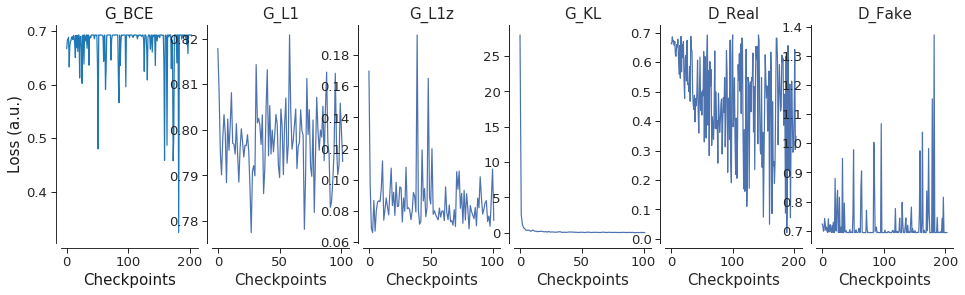

In [10]:
vis = Visualization()
vis.loss(solver.train_loss_history)

### Looking at predictions

In [11]:
vis = Visualization()


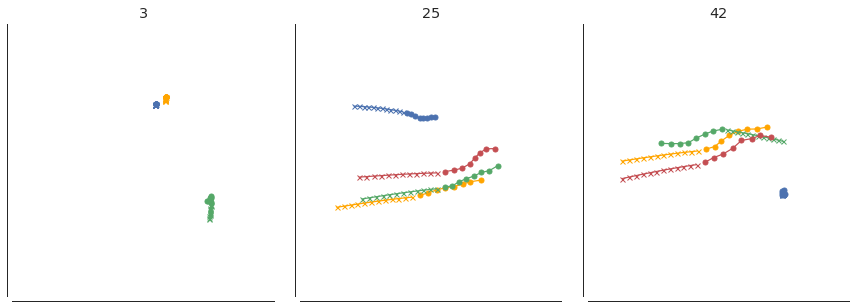

In [12]:
output = solver.test(testloader, load_checkpoint_from=filename)
vis.trajectories(output, scenes=[3,25,42])

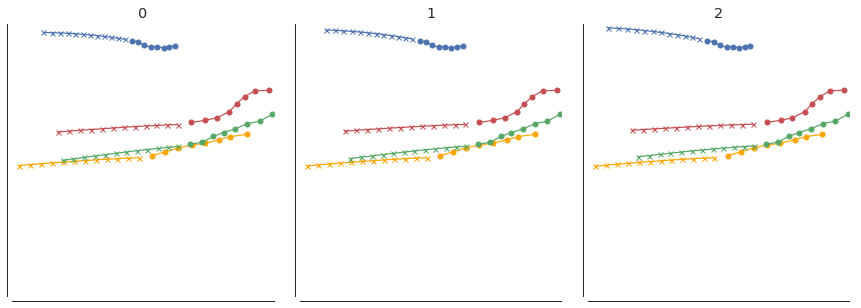

In [13]:
for s in [25]:
    out = solver.interpolate(testloader, scene=s, seed=10, stepsize=0.5)
    vis.trajectories(out, scenes = None)
    plt.show()

In [14]:
len(out['xy_pred'])

3